## YOLO + microsam prediction

Import Yolo and setup paths

In [ ]:
import numpy as np
import napari
print("Napari version:", napari.__version__)
from pathlib import Path
from segment_everything.weights_helper import get_weights_path
from segment_everything.prompt_generator import YoloDetector

Napari version: 0.6.6


/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/bnorthan/code/i2k/tnia/reproducible-dl-seg-article/pixi/microsam_cellposesam/.pixi/envs/default/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} 

In [2]:
tnia_images_path = Path(r"D:\images")
tnia_images_path = Path(r"/home/bnorthan/images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2025_05_10_SOTA_Test_Set')

Set up a bounding box detector.  Here I use a Yolo detector vendored from mobilesam, but any bounding box detector would work for this step. 

In [21]:
yolo_detector_object_aware = YoloDetector(str(get_weights_path("ObjectAwareModel")), "ObjectAwareModelFromMobileSamV2", device='cuda')

### Load test image

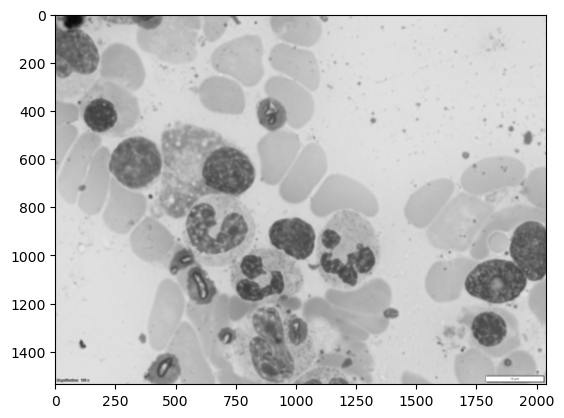

In [23]:
from skimage.io import imread
import matplotlib.pyplot as plt


img = imread(parent_path / r"TestHidden_005.bmp")

img = img.mean(axis=2).astype(np.uint8)

# due to bug in newer versions of Napari we make this a b&w image
plt.imshow(img, cmap='gray')

Generate bounding boxes with YOLO

In [25]:
results = yolo_detector_object_aware.get_results(img, conf=0.2, imgsz=512)


0: 416x512 87 objects, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)


Get the classes and the bounding boxes from the Yolo result.  Convert bbox to Napari and Microsam format. 

In [7]:
classes = results[0].boxes.cls.cpu().numpy()
bbs=results[0].boxes.xyxy.cpu().numpy()

bboxes = []
bboxes_for_napari = []
for box in bbs:
    bbox_napari = [[box[1], box[0]], [box[3], box[2]]]
    bboxes_for_napari.append(bbox_napari)
    bbox = [box[1], box[0], box[3], box[2]]
    bboxes.append(bbox)

In [8]:
from micro_sam.sam_annotator._state import AnnotatorState
from micro_sam.sam_annotator.util import prompt_segmentation
from micro_sam import prompt_based_segmentation


In [9]:
state = AnnotatorState()
state.reset_state()
state.initialize_predictor(
    img,
    model_type="vit_b_lm",
    ndim=2,
    #save_path=self.embedding_save_path,
)
        

Compute Image Embeddings 2D: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


In [10]:

prediction = prompt_based_segmentation.segment_from_box(
                    predictor, box, image_embeddings=image_embeddings, i=i
                ).squeeze()

NameError: name 'predictor' is not defined

In [11]:
# import stacked labels
from segment_everything.stacked_labels import StackedLabels

# Generate masks from bounding boxes
mask_list = []

for bbox in bboxes:
    bbox_ = np.array(bbox)
    print(bbox_)
    prediction =  prompt_based_segmentation.segment_from_box(
        state.predictor, bbox_, image_embeddings=state.image_embeddings)
    
    prediction = np.squeeze(prediction)
    
    print(prediction.shape, prediction.min(), prediction.max())
    mask = StackedLabels.create_mask_from_segmentation(prediction)

    mask_list.append(mask)

[     1019.1      1704.2      1199.6      1957.4]
(1536, 2040) False True
[     510.78      226.92      723.44      441.18]
(1536, 2040) False True
[     665.55      1063.3      839.74      1342.6]
(1536, 2040) False True
[     537.67       934.3      783.43      1128.9]
(1536, 2040) False True
[      88.88      651.45      298.56       864.9]
(1536, 2040) False True
[     551.71      613.48      748.75      829.45]
(1536, 2040) False True
[     683.71      1453.2      886.64      1656.7]
(1536, 2040) False True
[     260.53      873.87      473.39        1076]
(1536, 2040) False True
[     846.92      890.58      1018.7      1079.3]
(1536, 2040) False True
[     862.12      1890.8        1107        2040]
(1536, 2040) False True
[     592.21      1687.1      748.45      1952.9]
(1536, 2040) False True
[     744.21      1546.7      983.08      1818.8]
(1536, 2040) False True
[     258.16      598.92      413.12      787.53]
(1536, 2040) False True
[     1013.2        1539      1195.3  

In [12]:
len(mask_list)

87

In [13]:
stacked_labels = StackedLabels(mask_list)
stacked_labels.make_3d_label_image()


In [19]:
viewer = napari.Viewer()
viewer.add_image(img, name='image')
viewer.add_labels(stacked_labels.label_image, name='labels', scale=(3,1,1))

<Labels layer 'labels' at 0x7cc059560390>

In [20]:
shapes_layer = viewer.add_shapes(name='bboxes', face_color= 'transparent', edge_color='green', edge_width=3)

for bbox in bboxes_for_napari:
    shapes_layer.add_rectangles([bbox])